In [1]:
import sys
import os.path

sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy")

%load_ext autoreload
%autoreload 2

from numcosmo_py import Ncm, Nc, GObject

from richness_mass_calib import create_richness_mass_calib
import numpy as np
import math

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt

# Bibliotecas complementares
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
from sklearn.decomposition import PCA

import numpy as np
from scipy.stats import truncnorm

#Settings
Ncm.cfg_init()

%matplotlib inline
sys.path.insert(0, "/global/homes/c/cinlima/gcr-catalogs")


import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")

In [2]:
protodc2 = GCRCatalogs.load_catalog('proto-dc2_v3.0_redmapper')
protoDC2_v3_redmapper=Table(protodc2.get_quantities(['cluster_id','redshift_true_cluster','halo_mass','richness']))

protoDC2_v3_redmapper.rename_column('redshift_true_cluster', 'redshift_true')
protoDC2_v3_redmapper.rename_column('halo_mass', 'm200c')

dt_halos = protoDC2_v3_redmapper

cut=dt_halos['richness'] > 0
dt_halos = dt_halos[cut]

print(protodc2.get_catalog_info('description'))
print(protodc2.cosmology)


cluster catalog and member catalog from the redMaPPer cluster finder run on proto-dc2. Red
sequence was fit in the standard way, but centers are on halo centers, i.e. a real halo finding
run was not done.

FlatLambdaCDM(H0=71.0 km / (Mpc s), Om0=0.265, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.0448)


In [3]:
R_min = min(dt_halos["richness"])
R_max = max(dt_halos["richness"])

print(R_min, R_max)

3.0552082 66.10402


In [4]:
lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)


In [5]:
rmdata = create_richness_mass_calib(dt_halos)

ascaso = Nc.ClusterMassAscaso()

ascaso.param_set_by_name("mup0", 4.45393539397061)
ascaso.param_set_by_name("mup1", 0.688627943224023)
ascaso.param_set_by_name("mup2", 1.23735536845047)
ascaso.param_set_by_name("sigmap0", 0.227197277810533)
ascaso.param_set_by_name("sigmap1", -0.0514034833229222)
ascaso.param_set_by_name("sigmap2", -0.125446104089159)
ascaso.param_set_by_name("cut", 1e15)


lnrich_ext = Nc.ClusterMassLnrichExt()
lnrich_ext.param_set_by_name("mu", 4.60456407051582)
lnrich_ext.param_set_by_name("muM1", 0.872079943089853)
lnrich_ext.param_set_by_name("muZ1", 1.77432682440775)
lnrich_ext.param_set_by_name("muM2", 0.0417736274804596)
lnrich_ext.param_set_by_name("muZ2", -0.140721577418961)
lnrich_ext.param_set_by_name("muMZ", 0.142254333837774)

lnrich_ext.param_set_by_name("sigma0", 0.288099083637692)
lnrich_ext.param_set_by_name("sigmaM1", 0.01665425603827)
lnrich_ext.param_set_by_name("sigmaZ1", -0.0170544925340452)
lnrich_ext.param_set_by_name("sigmaM2", 0.0151710348889877)
lnrich_ext.param_set_by_name("sigmaZ2", 0.00841242091702829)
lnrich_ext.param_set_by_name("sigmaMZ", 0.0375086602261856)

lnrich_ext.param_set_by_name("cut", 1e15)
lnrich_ext.param_set_by_name("cutM1", 0)
lnrich_ext.param_set_by_name("cutZ1", 0)
    
mset_ext = Ncm.MSet()
mset_ext.set(lnrich_ext)

# lnR mean and std

def compute_res(rich_model):

    lnR_mean = np.array(
        [rich_model.get_mean_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )
    lnR_std = np.array(
        [rich_model.get_std_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )

    abs_err = (lnR - lnR_mean) / lnR_std
    # Data cut
    sigma_cut = 5.0

    sigma_cut_array = np.abs(abs_err) < sigma_cut
    print(f"Cutting {sigma_cut}-sigma, {np.sum(np.logical_not(sigma_cut_array))}")

    lnR_mean = lnR_mean[sigma_cut_array]
    z_sigma_cut = z[sigma_cut_array]
    lnM_sigma_cut = lnM[sigma_cut_array]
    abs_err = abs_err[sigma_cut_array]
    
    lnR_std=lnR_std[sigma_cut_array]
    dt_halos_res = dt_halos[sigma_cut_array]
    
    
    return abs_err, lnR_mean, z_sigma_cut, lnM_sigma_cut, lnR_std, dt_halos_res

res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso, lnR_std_ascaso, dt_halos_ascaso = compute_res(ascaso)
res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext, lnR_std_ext, dt_halos_ext = compute_res(lnrich_ext)


Cutting 5.0-sigma, 31
Cutting 5.0-sigma, 33


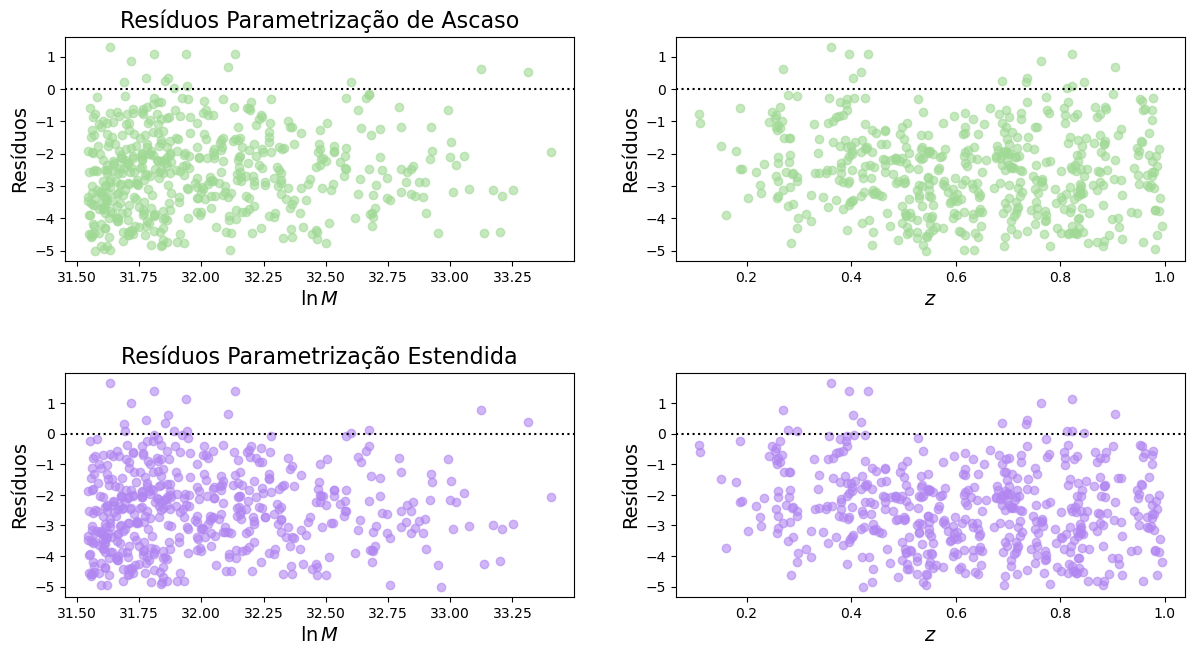

In [6]:
fig = plt.figure(figsize=(14,7))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.scatter(lnM_sigma_cut_ascaso, res_ascaso, c="#a0d995", alpha=0.6)
ax1.set_xlabel("$\ln M$", fontsize=14)
ax1.set_ylabel("Resíduos", fontsize=14)
ax1.axhline(y=0.0, color='black', linestyle='dotted')
ax1.set_title("Resíduos Parametrização de Ascaso", fontsize=16)

ax2.scatter(z_sigma_cut_ascaso, res_ascaso,  c="#a0d995", alpha=0.6)
ax2.set_xlabel("$z$", fontsize=14)
ax2.set_ylabel("Resíduos", fontsize=14)
ax2.axhline(y=0.0, color='black', linestyle='dotted')

ax3.scatter(lnM_sigma_cut_ext, res_ext, c="#b186f1", alpha=0.6)
ax3.set_xlabel("$\ln M$", fontsize=14)
ax3.set_ylabel("Resíduos", fontsize=14)
ax3.set_title("Resíduos Parametrização Estendida", fontsize=16)
ax3.axhline(y=0.0, color='black', linestyle='dotted')

ax4.scatter(z_sigma_cut_ext, res_ext, c="#b186f1", alpha=0.6)
ax4.set_xlabel("$z$", fontsize=14)
ax4.set_ylabel("Resíduos", fontsize=14)
ax4.axhline(y=0.0, color='black', linestyle='dotted')

plt.show()

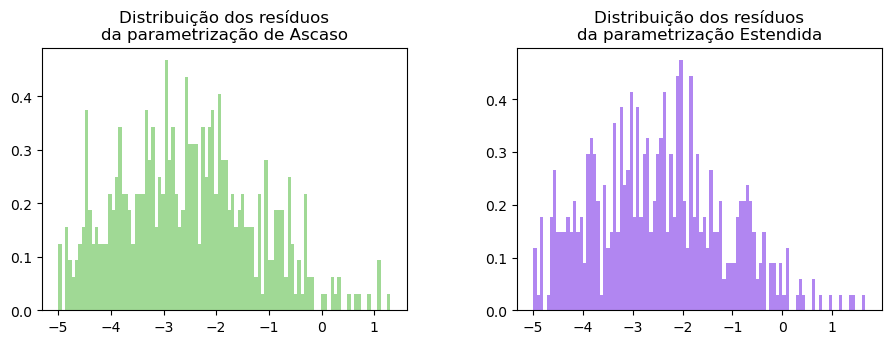

In [7]:
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

plt.subplots_adjust(left=0.2,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.3, 
                    hspace=0.4)

ax1.hist(res_ascaso, bins=100, density=True, color ="#a0d995")
ax1.set_title("Distribuição dos resíduos\nda parametrização de Ascaso")

ax2.hist(res_ext, bins=100, density=True, color="#b186f1")
ax2.set_title("Distribuição dos resíduos\nda parametrização Estendida")

plt.show()

In [8]:
print(stats.kstest(res_ascaso, stats.norm.cdf, args=(np.mean(res_ascaso), np.std(res_ascaso))))
print(stats.kstest(res_ext, stats.norm.cdf, args=(np.mean(res_ext), np.std(res_ext))))

KstestResult(statistic=0.033770764576461776, pvalue=0.5950377490079236, statistic_location=-3.1879056992668104, statistic_sign=1)
KstestResult(statistic=0.037012827428334616, pvalue=0.4795539572221832, statistic_location=-3.729709920234867, statistic_sign=1)
